# Results

### Check for errors

In [1]:
import src.utils as utils
from src.solvers import pg_solver
from ray import tune

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from tbparse import SummaryReader
import seaborn as sns; sns.set_theme()

2023-06-06 16:55:14.534851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 16:55:15.320349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
vars_list = [10, 20, 30]
exp_folder = 'hypersearch/pg_solver'

errors = {}
for num_vars in vars_list:
    # Get path for every hyperparameter search
    folder_n = os.path.join(exp_folder, f'{num_vars:04d}')
    folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
    folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
    folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

    # Count errors for every hyperparameter search
    errors[f'n={num_vars}'] = {}
    errors[f'n={num_vars}']['num_errors'] = 0
    for i, search_path in enumerate(folder_assumption):
        
        # Restore the GridSearch object
        restored_tuner = tune.Tuner.restore(path=search_path,
                                            trainable=pg_solver,
                                            resume_unfinished=False,
                                            resume_errored=False,
                                            restart_errored=False)
        results = restored_tuner.get_results()
                
        if results.num_errors > 0:
            #print(f'n={num_vars}, {search_path}, errors = {results.num_errors}, terminated = {results.num_terminated}')

            errors[f'n={num_vars}']['num_errors'] += 1
            errors[f'n={num_vars}'][f'{i}'] = f'path: {search_path}, errors: {results.errors}, num_errors: {results.num_errors},  terminated: {results.num_terminated}'

    errors[f'n={num_vars}']['num_searchs'] = len(folder_assumption)
    #print(f'Total errors for n = {num_vars}: {errors}. Total searchs: {len(folder_assumption)}\n')

/home/omargp/miniconda3/envs/sat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this sho

{'n=10': {'num_errors': 0, 'num_searchs': 120}, 'n=20': {'num_errors': 1, '23': 'path: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=03/node2vec, errors: [RayTaskError(ValueError)(ValueError("Expected parameter probs (Tensor of shape (32, 1, 1)) of distribution Bernoulli(probs: torch.Size([32, 1, 1])) to satisfy the constraint Interval(lower_bound=0.0, upper_bound=1.0), but found invalid values:\\ntensor([[[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]]

In [3]:
# Print keys and values
for key, value in errors.items():
    print(key)
    print(value)
    print('\n')

n=10
{'num_errors': 0, 'num_searchs': 120}


n=20
{'num_errors': 1, '23': 'path: hypersearch/pg_solver/0020/0030/rand_n=0020_k=03_m=0030_i=03/node2vec, errors: [RayTaskError(ValueError)(ValueError("Expected parameter probs (Tensor of shape (32, 1, 1)) of distribution Bernoulli(probs: torch.Size([32, 1, 1])) to satisfy the constraint Interval(lower_bound=0.0, upper_bound=1.0), but found invalid values:\\ntensor([[[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\n        [[nan]],\\n\\

# Results

### Why it is important to load dataframe instead of get_best_results

In [8]:
# Load best results
exp_path = 'hypersearch/pg_solver/0030/0135/rand_n=0030_k=03_m=0135_i=01/arch'

# Restore the GridSearch object
restored_tuner = tune.Tuner.restore(path=exp_path,
                                    trainable=pg_solver,
                                    resume_unfinished=False,
                                    resume_errored=False,
                                    restart_errored=False)

results = restored_tuner.get_results()

# Check if there have been errors
if results.errors:
    print("Errors reported.")
else:
    print("No errors reported.")

# Get best trial
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='last').metrics['num_sat_eval'])
print(results.get_best_result(metric='num_sat_eval', mode='max', scope='all').metrics['num_sat_eval'])
print(results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max())

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.


No errors reported.
129.0
125.0
130.0


In [63]:
num_vars = 40
exp_folder = 'hypersearch/pg_solver'

# Get path for every hyperparameter search
folder_n = os.path.join(exp_folder, f'{num_vars:04d}')
folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

# Build dictionary with best result for every hyperparameter search
dic_results = {}

for i, search_path in enumerate(folder_assumption):
    # Create experiment id
    split_path = search_path.split("/")
    n = split_path[2]
    m = split_path[3]
    i = split_path[4][-2:]
    s = split_path[5]
    exp_id = f'{n}/{m}/{i}/{s}'
    
    # Restore the GridSearch object
    restored_tuner = tune.Tuner.restore(path=search_path,
                                        trainable=pg_solver,
                                        resume_unfinished=False,
                                        resume_errored=False,
                                        restart_errored=False)
    results = restored_tuner.get_results()
    
    # Get best trial
    max_val = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max()
    # Update dict
    dic_results[exp_id] = [int(n), int(m), int(i), s, max_val]

# Create dataframe
columns = ['n', 'm', 'i', 'search', 'num_sat_eval']
df = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
df.insert(2, 'r', df['m'] / df['n'])
df.insert(6, 'frac_sat', df['num_sat_eval'] / df['m'])

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

/tmp/ipykernel_68944/3061195214.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')


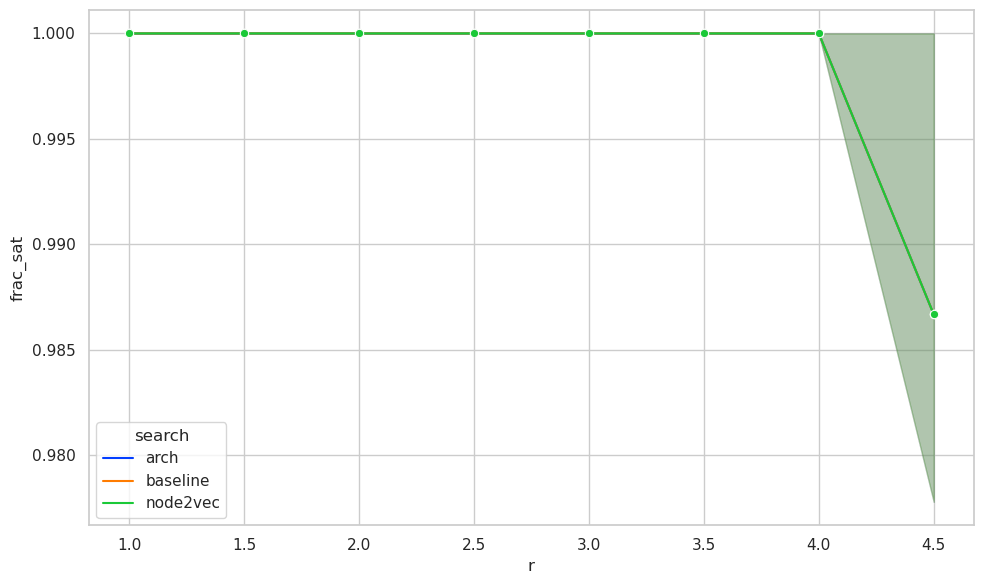

In [37]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [51]:
# Unique values of num_sat_eval when r = 4.5
df[df['r'] == 4.5]['num_sat_eval']

0010/0045/01/arch        44.0
0010/0045/01/baseline    44.0
0010/0045/01/node2vec    44.0
0010/0045/02/arch        44.0
0010/0045/02/baseline    44.0
0010/0045/02/node2vec    44.0
0010/0045/03/arch        44.0
0010/0045/03/baseline    44.0
0010/0045/03/node2vec    44.0
0010/0045/04/arch        45.0
0010/0045/04/baseline    45.0
0010/0045/04/node2vec    45.0
0010/0045/05/arch        45.0
0010/0045/05/baseline    45.0
0010/0045/05/node2vec    45.0
Name: num_sat_eval, dtype: float64

/tmp/ipykernel_68944/3061195214.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')


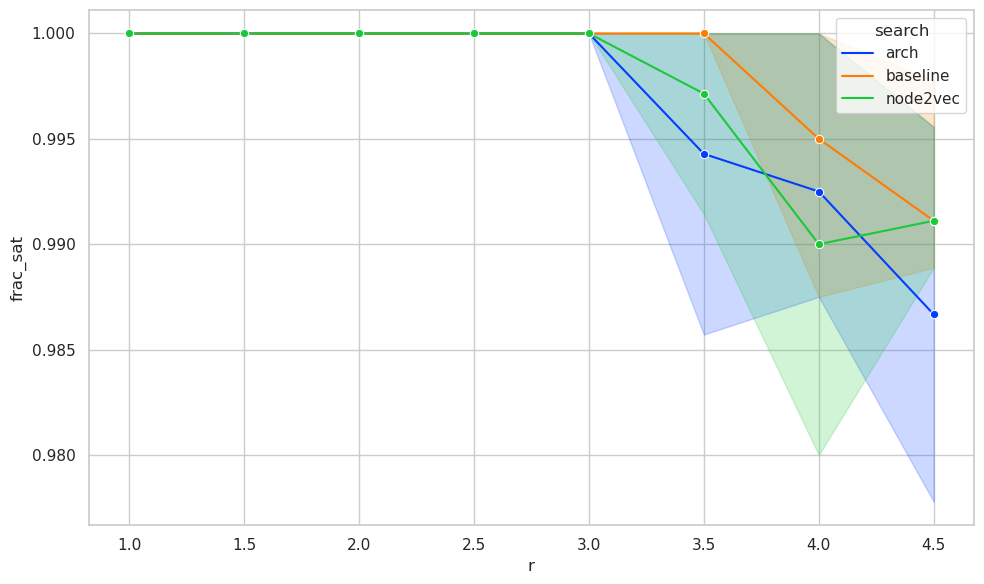

In [61]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [62]:
# Unique values of num_sat_eval when r = 4.5
df[df['r'] == 4.0]['num_sat_eval']

0020/0080/01/arch        80.0
0020/0080/01/baseline    80.0
0020/0080/01/node2vec    80.0
0020/0080/02/arch        79.0
0020/0080/02/baseline    79.0
0020/0080/02/node2vec    79.0
0020/0080/03/arch        79.0
0020/0080/03/baseline    80.0
0020/0080/03/node2vec    79.0
0020/0080/04/arch        79.0
0020/0080/04/baseline    79.0
0020/0080/04/node2vec    78.0
0020/0080/05/arch        80.0
0020/0080/05/baseline    80.0
0020/0080/05/node2vec    80.0
Name: num_sat_eval, dtype: float64

/tmp/ipykernel_68944/3061195214.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')


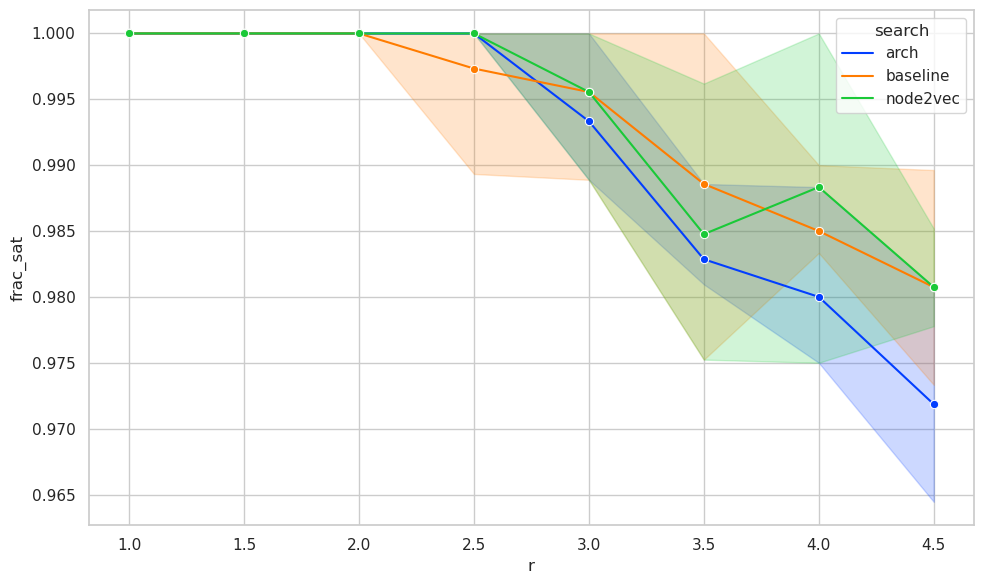

In [43]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

/tmp/ipykernel_68944/3061195214.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')


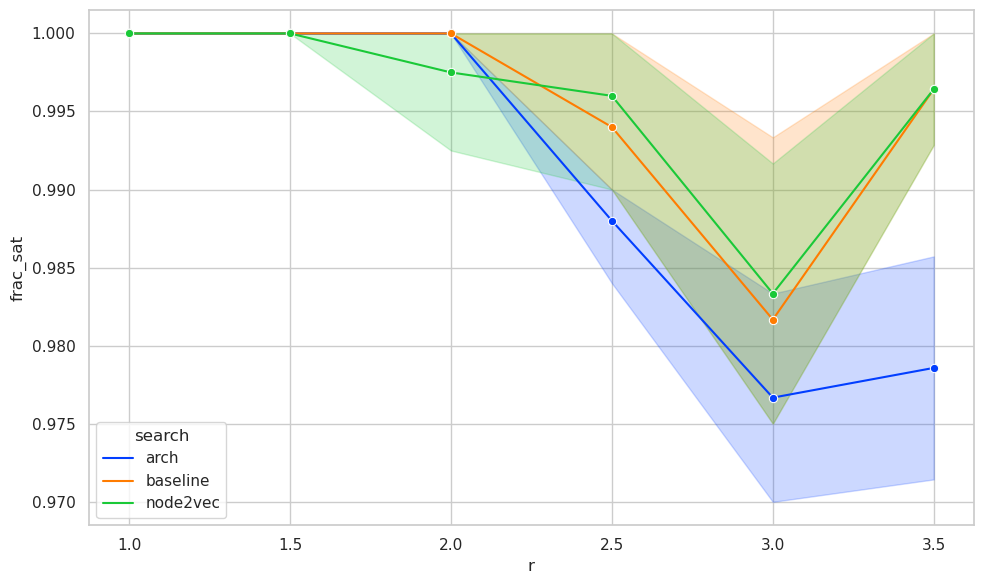

In [64]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()

In [74]:
exp_folder = 'hypersearch/pg_solver'

# Find folders (for each n) inside exp_folder
folders_n = sorted([os.path.join(exp_folder, folder) for folder in os.listdir(exp_folder)])

dic_results = {}

# Get path for every hyperparameter search
for folder_n in folders_n:
    folder_clauses = sorted([os.path.join(folder_n, folder) for folder in os.listdir(folder_n)])
    folder_instances = sorted([os.path.join(folder, instance) for folder in folder_clauses for instance in os.listdir(folder)])
    folder_assumption = sorted([os.path.join(folder, assumption) for folder in folder_instances for assumption in os.listdir(folder)])

    # Build dictionary with best result for every hyperparameter search
    for i, search_path in enumerate(folder_assumption):
        # Create experiment id
        split_path = search_path.split("/")
        n = split_path[2]
        m = split_path[3]
        i = split_path[4][-2:]
        s = split_path[5]
        exp_id = f'{n}/{m}/{i}/{s}'
        
        # Restore the GridSearch object
        restored_tuner = tune.Tuner.restore(path=search_path,
                                            trainable=pg_solver,
                                            resume_unfinished=False,
                                            resume_errored=False,
                                            restart_errored=False)
        results = restored_tuner.get_results()
        
        # Get best trial
        max_val = results.get_dataframe(filter_metric='num_sat_eval', filter_mode='max')['num_sat_eval'].max()
        # Update dict
        dic_results[exp_id] = [int(n), int(m), int(i), s, max_val]

# Create dataframe
columns = ['n', 'm', 'i', 'search', 'num_sat_eval']
df = pd.DataFrame.from_dict(dic_results, orient='index', columns=columns)
df.insert(2, 'r', df['m'] / df['n'])
df.insert(6, 'frac_sat', df['num_sat_eval'] / df['m'])

The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passed into the initial `Tuner` object.
The trainable will be overwritten - this should be done with caution: it's possible to supply an incompatible trainable, and there are no guarantees that the resumed experiment will continue successfully. If you encounter errors during training, ensure that you are passing in the same trainable that was passe

In [75]:

df

,n,m,r,i,search,num_sat_eval,frac_sat
0010/0010/01/arch,10,10,1.0,1,arch,10.0,1.000000
0010/0010/01/baseline,10,10,1.0,1,baseline,10.0,1.000000
0010/0010/01/node2vec,10,10,1.0,1,node2vec,10.0,1.000000
0010/0010/02/arch,10,10,1.0,2,arch,10.0,1.000000
0010/0010/02/baseline,10,10,1.0,2,baseline,10.0,1.000000
...,...,...,...,...,...,...,...
0040/0140/01/baseline,40,140,3.5,1,baseline,140.0,1.000000
0040/0140/01/node2vec,40,140,3.5,1,node2vec,140.0,1.000000
0040/0140/02/arch,40,140,3.5,2,arch,138.0,0.985714
0040/0140/02/baseline,40,140,3.5,2,baseline,139.0,0.992857


/tmp/ipykernel_68944/522256289.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')


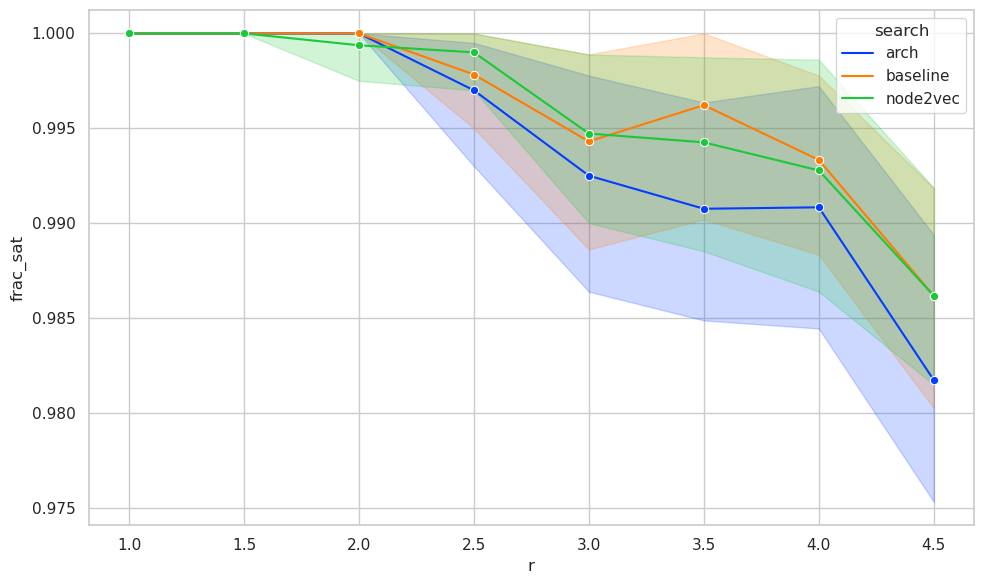

In [77]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid", palette="bright")
#color_pallete = sns.color_palette("bright")

sns.lineplot(data=df, x="r", y="frac_sat", hue="search", errorbar={'ci', 99}, palette=color_pallete, marker='o')
plt.tight_layout()
plt.show()